# CF Recommendation System

**Aim:** The aim of this project is to build a CF recommendation engine using the **Book-Crossing** dataset.

In [3]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from surprise import Reader, Dataset
from surprise import model_selection, accuracy
from surprise import NMF
from surprise import SVD
from surprise import SVDpp
from surprise import CoClustering
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
plt.style.use('seaborn-white') # Use seaborn-style plots
%matplotlib inline

#Read files.
import os
global directory; directory = '../BookRating'
def files(): return os.listdir(directory)

Users = pd.read_csv('BX-Users.csv', sep = ";", encoding='cp1252')
Ratings = pd.read_csv('BX-Book-Ratings.csv', sep = ";", encoding='cp1252')
Books = pd.read_csv('BX-Books.csv', sep=";", usecols=range(5), encoding ='iso-8859-1')


#Clean data with replacement of missing and invalid data
#Users 
Users.columns = Users.columns.str.strip().str.lower().str.replace('-', '_')
Users.user_id = Users.user_id.astype(int)
#User ages
#invalid ages of users such as, 224 years old and 0 years old observed
std = Users.age.std(); mode = int(Users.age.mode().values.tolist()[0]); len_fillna = len(Users.index)
#learn stasticis of data
df_copy = Users.copy()
df_normalize = df_copy.age.value_counts().rename_axis('age').reset_index(name = 'user_counts') 
df_normalize = df_normalize.sort_values(by=['age'])
df_normalize['id'] = df_copy['user_id']
df_normalize = df_normalize.assign(precent_counts=lambda x: x.user_counts.cumsum() / x.user_counts.sum())
#define where the 0.5% to 99.5% user count of age interval is 
age_high = max(df_normalize.loc[(df_normalize['precent_counts'] >= 0.005) &\
                                (df_normalize['precent_counts'] <= 0.995)].age.unique().tolist())
age_low = min(df_normalize.loc[(df_normalize['precent_counts'] >= 0.005) & \
                               (df_normalize['precent_counts'] <= 0.995)].age.unique().tolist())
#fill invalid and missing ages with random normal distributed numbers
#shifting mean to mode(mean = mode in normaldistribution)
fillna_list = (np.random.normal(mode, std, 1000)).tolist()
Users.loc[(Users.age<5) | (Users.age>90), 'age'] = np.nan
Users.age = Users.age.fillna(pd.Series(fillna_list))
#User locations
#originally format: location : 'farnborough, hants, united kingdom'
#break into three columns to better check validity
tmp_list = Users.location.str.split(',', 2, expand=True)
tmp_list.describe(include=[object])
#fill nan with 'other'
tmp_list.fillna('other', inplace=True)
Users['city'] = tmp_list[0];Users['state'] = tmp_list[1];Users['country'] = tmp_list[2]
Users.drop(columns=['location'], inplace=True)

#Books
Books.columns = Books.columns.str.strip().str.lower().str.replace('-', '_')
Books.year_of_publication = pd.to_numeric(Books.year_of_publication, errors='coerce')
#replace outscaled publication years
std = Books.year_of_publication.std()
mode = int(Books.year_of_publication.mode().values.tolist()[0])
len_fillna = len(Books.index)
#learn statistical information of book counts on year of publication
df_normalize={}
df_copy = Books.copy()
df_copy.year_of_publication.replace(0, np.nan, inplace=True)
df_normalize = df_copy.year_of_publication.value_counts().rename_axis('year').reset_index(name = 'book_counts') 
df_normalize = df_normalize.sort_values(by=['year'])
df_normalize['id'] = df_copy['isbn']
df_normalize = df_normalize.assign(precent_counts=lambda x: x.book_counts.cumsum() / x.book_counts.sum())
year_high = max(df_normalize.loc[(df_normalize['precent_counts'] >= 0.005) &\
                                 (df_normalize['precent_counts'] <= 0.995)].year.unique().tolist())
year_low = min(df_normalize.loc[(df_normalize['precent_counts'] >= 0.005) &\
                                (df_normalize['precent_counts'] <= 0.995)].year.unique().tolist())
#fill outscaled year and missing year(originally nan, became 0 after to_numeric)
fillna_list = (np.random.normal(mode, std, 1000)).tolist()
Books.loc[(Books.year_of_publication<1960) | (Books.year_of_publication>2020), 'year_of_publication'] = np.nan
Books.year_of_publication = Books.year_of_publication.fillna(pd.Series(fillna_list))
#we cannot recommend books without a title...
Books.dropna(subset=['book_title'], inplace=True)

#Ratings
Ratings.columns = Ratings.columns.str.strip().str.lower().str.replace('-', '_')
#extract explict ratings: 1-10
Ratings_ex = Ratings[Ratings.book_rating != 0]
#rescale with corrected user and book IDs from Users and Books
Book_Ratings_ex = Ratings_ex[Ratings_ex.isbn.isin(Books.isbn)]
User_Book_Ratings_ex = Book_Ratings_ex[Book_Ratings_ex.user_id.isin(Users.user_id)]
#Copy unprocessed df for plotting
User_Book_Ratings_ = User_Book_Ratings_ex.copy()#this only for plotting
#locate lazy users with ratings <10
df_copy = User_Book_Ratings_ex.copy()
df_normalize = df_copy.user_id.value_counts().rename_axis('user_id').reset_index(name = 'ratings_counts')
df_normalize = df_normalize.sort_values(by=['ratings_counts'])
lazy_users = df_normalize.loc[(df_normalize.ratings_counts < 10),'user_id'].unique().tolist()
#remove rows with lazy users
User_Book_Ratings_ex.loc[(User_Book_Ratings_ex['user_id'].isin(lazy_users))] = np.nan
User_Book_Ratings_ex.dropna(inplace=True)
#books with ratings
Book_with_r = User_Book_Ratings_ex.join(Books.set_index('isbn'), on='isbn')
#book,users with ratings
User_Book_r = Book_with_r.join(Users.set_index('user_id'), on='user_id')

#Surprise Read
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(User_Book_Ratings_ex[['user_id', 'isbn', 'book_rating']], reader)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
data

In [5]:
data_train = Dataset.load_from_df(User_Book_Ratings_ex[['user_id', 'isbn', 'book_rating']], reader)
data_test = Dataset.load_from_df(User_Book_Ratings_ex[['user_id', 'isbn', 'book_rating']], reader)
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

In [6]:
from collections import defaultdict
def precision_recall_at_k(predictions, k = 10, threshold = 5):
    
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        
        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        
        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    
    return precisions, recalls;

In [7]:
def get_precision_vs_recall(algo, k_max = 10, verbose = False):
    precision_list = []
    recall_list = []
    f1_score_list = []
    
    if algo:
        for k_curr in range(1, k_max + 1):
            algo.fit(data_train)
            predictions = algo.test(data_testset)
            
            # Get precision and recall at k metrics for each user
            precisions, recalls = precision_recall_at_k(predictions, k = k_curr, threshold = 5)
            
            # Precision and recall can then be averaged over all users
            precision = sum(prec for prec in precisions.values()) / len(precisions)
            recall = sum(rec for rec in recalls.values()) / len(recalls)
            f1_score = 2 * (precision * recall) / (precision + recall)
            
            # Save measures
            precision_list.append(precision)
            recall_list.append(recall)
            f1_score_list.append(f1_score)
            
            if verbose:
                print('K =', k_curr, '- Precision:', precision, ', Recall:', recall, ', F1 score:', f1_score)
    
    return {'precision': precision_list, 'recall': recall_list, 'f1_score': f1_score_list};

### SVD model

**_Using cross-validation (5 folds)_**

In [8]:
# Load SVD algorithm
data = Dataset.load_from_df(User_Book_Ratings_ex[['user_id', 'isbn', 'book_rating']], reader)
model = SVD()
# Train on books dataset
%time model_selection.cross_validate(model, data, measures=['RMSE','MAE'],cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5698  1.5756  1.5752  1.5691  1.5769  1.5733  0.0032  
MAE (testset)     1.2031  1.2077  1.2073  1.2016  1.2091  1.2057  0.0029  
Fit time          16.86   16.68   17.18   17.87   17.18   17.15   0.41    
Test time         0.56    0.55    1.10    1.14    0.57    0.78    0.28    
CPU times: user 1min 35s, sys: 785 ms, total: 1min 36s
Wall time: 1min 37s


{'fit_time': (16.860729455947876,
  16.679818153381348,
  17.183526039123535,
  17.868391275405884,
  17.178322553634644),
 'test_mae': array([1.20305798, 1.20771577, 1.20727391, 1.20158477, 1.2091107 ]),
 'test_rmse': array([1.56982933, 1.57564833, 1.57515131, 1.56914149, 1.57689657]),
 'test_time': (0.5554273128509521,
  0.5539186000823975,
  1.1023268699645996,
  1.1365149021148682,
  0.5650942325592041)}

In [9]:
k_max = 10
metrics = get_precision_vs_recall(model, k_max, True)
np.mean(metrics['f1_score'])

K = 1 - Precision: 0.9998482319016543 , Recall: 0.05579733130914479 , F1 score: 0.10569620144965058
K = 2 - Precision: 0.9999241159508271 , Recall: 0.11158984458342144 , F1 score: 0.2007736846427666
K = 3 - Precision: 0.999797642535539 , Recall: 0.16719300361234304 , F1 score: 0.28647902433808176
K = 4 - Precision: 0.9998102898770679 , Recall: 0.2227130624898658 , F1 score: 0.3642806677455906
K = 5 - Precision: 0.9995446957049631 , Recall: 0.27808796711691974 , F1 score: 0.4351193587320559
K = 6 - Precision: 0.999134921839429 , Recall: 0.3330542531117816 , F1 score: 0.49957789990797125
K = 7 - Precision: 0.9985473624872622 , Recall: 0.38787846561885575 , F1 score: 0.5587244711653905
K = 8 - Precision: 0.9978295355173485 , Recall: 0.44204115267307115 , F1 score: 0.6126685148451217
K = 9 - Precision: 0.99597459209312 , Recall: 0.4946891994966288 , F1 score: 0.6610449337554234
K = 10 - Precision: 0.9916357107926367 , Recall: 0.5438960904203768 , F1 score: 0.7024885916335728


0.4426853348215626

In [10]:
# Load NMF algorithm
data = Dataset.load_from_df(User_Book_Ratings_ex[['user_id', 'isbn', 'book_rating']], reader)
model1 = NMF()
# Train on books dataset
%time model_selection.cross_validate(model1, data, measures=['RMSE','MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.4806  2.4921  2.4933  2.5014  2.4794  2.4894  0.0083  
MAE (testset)     2.0750  2.0864  2.0833  2.0928  2.0741  2.0823  0.0070  
Fit time          31.31   39.36   31.79   31.08   33.27   33.36   3.09    
Test time         0.56    1.02    0.47    0.53    0.47    0.61    0.21    
CPU times: user 2min 52s, sys: 983 ms, total: 2min 53s
Wall time: 2min 58s


{'fit_time': (31.311033964157104,
  39.36028790473938,
  31.789538860321045,
  31.080713510513306,
  33.26743459701538),
 'test_mae': array([2.07502911, 2.08635141, 2.0833456 , 2.09275141, 2.07409809]),
 'test_rmse': array([2.48059309, 2.49211297, 2.49331934, 2.50142588, 2.47936988]),
 'test_time': (0.557966947555542,
  1.0183773040771484,
  0.47131800651550293,
  0.5309674739837646,
  0.46712732315063477)}

In [11]:
k_max = 10
metrics = get_precision_vs_recall(model1, k_max, True)
np.mean(metrics['f1_score'])

K = 1 - Precision: 1.0 , Recall: 0.05524559890643533 , F1 score: 0.10470661799241249
K = 2 - Precision: 1.0 , Recall: 0.1098057269975583 , F1 score: 0.19788279034137637
K = 3 - Precision: 1.0 , Recall: 0.16334331963326854 , F1 score: 0.28081705009448243
K = 4 - Precision: 1.0 , Recall: 0.21592285522881424 , F1 score: 0.3551588068277268
K = 5 - Precision: 1.0 , Recall: 0.26688848517970687 , F1 score: 0.4213290882375476
K = 6 - Precision: 1.0 , Recall: 0.3158776216621674 , F1 score: 0.4801018217228477
K = 7 - Precision: 1.0 , Recall: 0.3617987975993809 , F1 score: 0.5313542620792007
K = 8 - Precision: 0.9999810289877068 , Recall: 0.4042794876275877 , F1 score: 0.575778943085118
K = 9 - Precision: 1.0 , Recall: 0.441830938923261 , F1 score: 0.6128748204740483
K = 10 - Precision: 1.0 , Recall: 0.47361271837192387 , F1 score: 0.6427913012248978


0.4202795502079658

In [12]:
data = Dataset.load_from_df(User_Book_Ratings_ex[['user_id', 'isbn', 'book_rating']], reader)
CoClusteringmodel = CoClustering()

%time model_selection.cross_validate(CoClusteringmodel, data, measures=['RMSE','MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.8503  1.8442  1.8490  1.8392  1.8295  1.8424  0.0076  
MAE (testset)     1.4350  1.4334  1.4331  1.4286  1.4190  1.4298  0.0058  
Fit time          17.86   18.11   18.21   18.39   18.13   18.14   0.17    
Test time         0.41    0.91    0.94    0.43    0.42    0.62    0.25    
CPU times: user 1min 40s, sys: 1.69 s, total: 1min 42s
Wall time: 1min 41s


{'fit_time': (17.85654902458191,
  18.105318069458008,
  18.209877252578735,
  18.394307136535645,
  18.134732723236084),
 'test_mae': array([1.43503875, 1.43336576, 1.43306204, 1.42860888, 1.41898729]),
 'test_rmse': array([1.85027006, 1.84417221, 1.84901418, 1.83917768, 1.82947324]),
 'test_time': (0.4101369380950928,
  0.9138638973236084,
  0.9407472610473633,
  0.4281480312347412,
  0.4210042953491211)}

In [13]:
k_max = 10
metrics = get_precision_vs_recall(CoClusteringmodel, k_max, True)
np.mean(metrics['f1_score'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


K = 1 - Precision: 0.9969646380330854 , Recall: 0.05512642109162179 , F1 score: 0.10447592339657687
K = 2 - Precision: 0.9976475944756412 , Recall: 0.11004552557129002 , F1 score: 0.19822575744508308
K = 3 - Precision: 0.9949410633884769 , Recall: 0.16373907926880796 , F1 score: 0.2812005274766217
K = 4 - Precision: 0.9942707542874489 , Recall: 0.2165629003373678 , F1 score: 0.355659354935639
K = 5 - Precision: 0.9930641979056036 , Recall: 0.26992855848645086 , F1 score: 0.42447810736604713
K = 6 - Precision: 0.9919158192947816 , Recall: 0.32199724299643673 , F1 score: 0.48617243905088786
K = 7 - Precision: 0.9897299973259928 , Recall: 0.3714519956040015 , F1 score: 0.5401734441469219
K = 8 - Precision: 0.9894698234431125 , Recall: 0.42074086573055813 , F1 score: 0.5904229677533639
K = 9 - Precision: 0.9888706405818194 , Recall: 0.4714597772805751 , F1 score: 0.6385030761058008
K = 10 - Precision: 0.9860509459006882 , Recall: 0.5067618906964805 , F1 score: 0.6694650922304823


0.4288776689907425

In [14]:
data = Dataset.load_from_df(User_Book_Ratings_ex[['user_id', 'isbn', 'book_rating']], reader)
KNNBasicmodel = KNNBasic()

%time model_selection.cross_validate(KNNBasicmodel, data, measures=['RMSE','MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9587  1.9406  1.9437  1.9563  1.9329  1.9465  0.0097  
MAE (testset)     1.5357  1.5272  1.5221  1.5333  1.5148  1.5266  0.0076  
Fit time          2.55    2.26    2.17    2.22    2.12    2.27    0.15    
Test time         2.16    1.62    1.67    1.58    1.67    1.74    0.21    
CPU times: user 26.9 s, sys: 1.42 s, total: 28.4 s
Wall time: 28.3 s


{'fit_time': (2.553802251815796,
  2.2631804943084717,
  2.17229962348938,
  2.2227072715759277,
  2.1216893196105957),
 'test_mae': array([1.53568448, 1.52721484, 1.52208477, 1.53332085, 1.51481764]),
 'test_rmse': array([1.95873193, 1.94061303, 1.94369141, 1.95633579, 1.93290972]),
 'test_time': (2.1592721939086914,
  1.6186013221740723,
  1.6732285022735596,
  1.578540563583374,
  1.665600061416626)}

In [15]:
k_max = 10
metrics = get_precision_vs_recall(KNNBasicmodel, k_max, True)
np.mean(metrics['f1_score'])

Computing the msd similarity matrix...
Done computing similarity matrix.
K = 1 - Precision: 1.0 , Recall: 0.0558141944311832 , F1 score: 0.10572730453061001
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 2 - Precision: 1.0 , Recall: 0.1116283888623664 , F1 score: 0.2008376000123678
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 3 - Precision: 1.0 , Recall: 0.16744258329355116 , F1 score: 0.2868536503459855
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 4 - Precision: 0.9998861739262407 , Recall: 0.22311344118740634 , F1 score: 0.364821120634061
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 5 - Precision: 0.9996281681590531 , Recall: 0.27855444078094754 , F1 score: 0.43569809731857934
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 6 - Precision: 0.9994005160115341 , Recall: 0.33377167521692325 , F1 score: 0.5004178554526498
Computing the 

0.4434257633243134

In [16]:
data = Dataset.load_from_df(User_Book_Ratings_ex[['user_id', 'isbn', 'book_rating']], reader)
KNNWithMeansmodel = KNNWithMeans()

%time model_selection.cross_validate(KNNWithMeansmodel, data, measures=['RMSE','MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.8018  1.8028  1.7995  1.7979  1.7867  1.7977  0.0058  
MAE (testset)     1.3951  1.3950  1.3936  1.3913  1.3822  1.3915  0.0048  
Fit time          2.24    2.58    2.35    2.34    2.34    2.37    0.11    
Test time         1.67    2.12    1.63    1.68    1.64    1.75    0.19    
CPU times: user 27.9 s, sys: 508 ms, total: 28.4 s
Wall time: 28.3 s


{'fit_time': (2.2382547855377197,
  2.584491491317749,
  2.3508167266845703,
  2.3363006114959717,
  2.343946933746338),
 'test_mae': array([1.39512443, 1.39499211, 1.39363963, 1.39132508, 1.38221081]),
 'test_rmse': array([1.80180157, 1.8027624 , 1.79954527, 1.79789857, 1.78665994]),
 'test_time': (1.6724491119384766,
  2.1204934120178223,
  1.6290514469146729,
  1.6759097576141357,
  1.6406056880950928)}

In [17]:
k_max = 10
metrics = get_precision_vs_recall(KNNWithMeansmodel, k_max, True)
np.mean(metrics['f1_score'])

Computing the msd similarity matrix...
Done computing similarity matrix.
K = 1 - Precision: 1.0 , Recall: 0.0557610755967622 , F1 score: 0.10563199740100972
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 2 - Precision: 1.0 , Recall: 0.11139784589392698 , F1 score: 0.20046439050694165
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 3 - Precision: 1.0 , Recall: 0.16678232636527177 , F1 score: 0.28588421781263607
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 4 - Precision: 1.0 , Recall: 0.22189241975087412 , F1 score: 0.36319469073409055
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 5 - Precision: 0.9999696463803309 , Recall: 0.27676027864209213 , F1 score: 0.4335323744542044
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 6 - Precision: 0.999893762331158 , Recall: 0.3311963249486476 , F1 score: 0.49757885298343946
Computing the msd similari

0.4404865227507238

In [18]:
data = Dataset.load_from_df(User_Book_Ratings_ex[['user_id', 'isbn', 'book_rating']], reader)
KNNWithZScoremodel = KNNWithZScore()

%time model_selection.cross_validate(KNNWithZScoremodel, data, measures=['RMSE','MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.7980  1.7974  1.7868  1.7961  1.7971  1.7951  0.0042  
MAE (testset)     1.3805  1.3810  1.3760  1.3807  1.3839  1.3804  0.0025  
Fit time          2.74    3.62    3.00    3.22    2.80    3.07    0.32    
Test time         2.62    2.36    1.82    1.85    1.84    2.10    0.33    
CPU times: user 32.6 s, sys: 808 ms, total: 33.4 s
Wall time: 33.5 s


{'fit_time': (2.736492872238159,
  3.619499683380127,
  2.9959449768066406,
  3.217536211013794,
  2.8025307655334473),
 'test_mae': array([1.38047331, 1.38104378, 1.37600641, 1.38074127, 1.3838764 ]),
 'test_rmse': array([1.7979807 , 1.79737705, 1.78679414, 1.79610761, 1.79707373]),
 'test_time': (2.620856761932373,
  2.362548351287842,
  1.8189725875854492,
  1.850837230682373,
  1.835280418395996)}

In [19]:
k_max = 10
metrics = get_precision_vs_recall(KNNWithZScoremodel, k_max, True)
np.mean(metrics['f1_score'])

Computing the msd similarity matrix...
Done computing similarity matrix.
K = 1 - Precision: 1.0 , Recall: 0.0557610755967622 , F1 score: 0.10563199740100972
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 2 - Precision: 1.0 , Recall: 0.11137399662132981 , F1 score: 0.2004257737897703
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 3 - Precision: 1.0 , Recall: 0.16677173216360153 , F1 score: 0.2858686537671745
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 4 - Precision: 1.0 , Recall: 0.2218711656470582 , F1 score: 0.3631662189680421
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 5 - Precision: 1.0 , Recall: 0.27674753717199757 , F1 score: 0.43351959430443826
Computing the msd similarity matrix...
Done computing similarity matrix.
K = 6 - Precision: 0.9999494106338848 , Recall: 0.3310665599816539 , F1 score: 0.49743927772879526
Computing the msd similarity matrix...
Done

0.4402068340995938

# Comparison of different Algorithms on RMSE

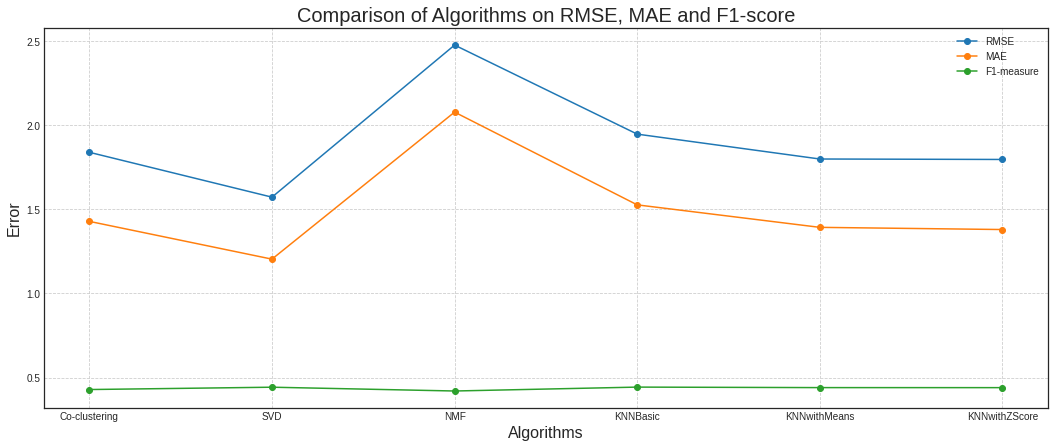

In [20]:
import matplotlib.pyplot as plt
Algorithms = ['Co-clustering' ,'SVD','NMF','KNNBasic','KNNwithMeans','KNNwithZScore']
#mannullt recode...since re-running takes too much time
mae_results =[1.4286,1.2041,2.0782,1.5268,1.3931,1.3801]
rmse_results =[1.8393,1.5726,2.4767,1.9473,1.7994,1.7967]
f1_results =[0.4289,0.4428,0.4202,0.4434,0.4404,0.4402]
plt.figure(figsize=(18,7))
plt.title('Comparison of Algorithms on RMSE, MAE and F1-score', loc='center', fontsize=20)
plt.plot(Algorithms, rmse_results, label='RMSE', marker='o')
plt.plot(Algorithms, mae_results, label='MAE', marker='o')
plt.plot(Algorithms, f1_results, label='F1-measure', marker='o')
plt.xlabel('Algorithms', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.grid(ls='dashed')
plt.legend()
plt.show()
